In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid

### Load dataset

In [3]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model definition

In [4]:
class AE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2, device=device):
        super(AE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
            )
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
        
    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        x = self.encode(x)
        x_hat = self.decode(x)
        return x_hat

### Model initialization

In [6]:
model = AE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

def loss_function(x, x_hat):
    return nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

### Train

In [8]:
x_dim = 784

def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat = model(x)
            loss = loss_function(x, x_hat)
            
            overall_loss += loss.item() #Зачем она? 
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

train(model, optimizer, epochs=20, device=device)

	Epoch 1 	Average Loss:  173.7253184669762
	Epoch 2 	Average Loss:  168.5891274193969
	Epoch 3 	Average Loss:  166.26218169605593
	Epoch 4 	Average Loss:  164.19269891551022
	Epoch 5 	Average Loss:  163.30594946655884
	Epoch 6 	Average Loss:  162.59572308013355
	Epoch 7 	Average Loss:  162.2981606062187
	Epoch 8 	Average Loss:  161.41056877021597
	Epoch 9 	Average Loss:  161.1764715117644
	Epoch 10 	Average Loss:  160.6176689828099
	Epoch 11 	Average Loss:  159.63857770763772
	Epoch 12 	Average Loss:  159.25680442338793
	Epoch 13 	Average Loss:  159.03365457729026
	Epoch 14 	Average Loss:  158.55898750521703
	Epoch 15 	Average Loss:  158.09984156536936
	Epoch 16 	Average Loss:  157.7271189286832
	Epoch 17 	Average Loss:  157.85117195651605
	Epoch 18 	Average Loss:  159.1898924640025
	Epoch 19 	Average Loss:  156.9816617050553
	Epoch 20 	Average Loss:  156.25720324890443


9359806.474609375

 ### Save and load

In [ ]:
torch.save(model.state_dict(), 'VAE_nll_reduction_mean.pt')

### Generation

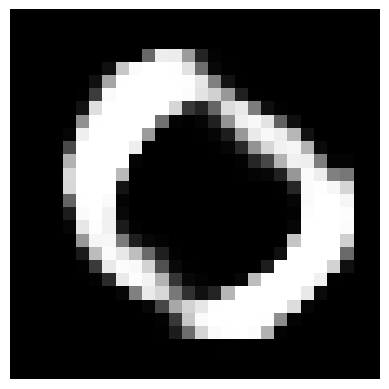

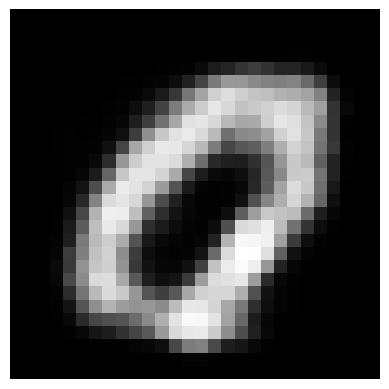

(None, None)

In [9]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.35, -0.55), generate_digit(1.0, 0.0)

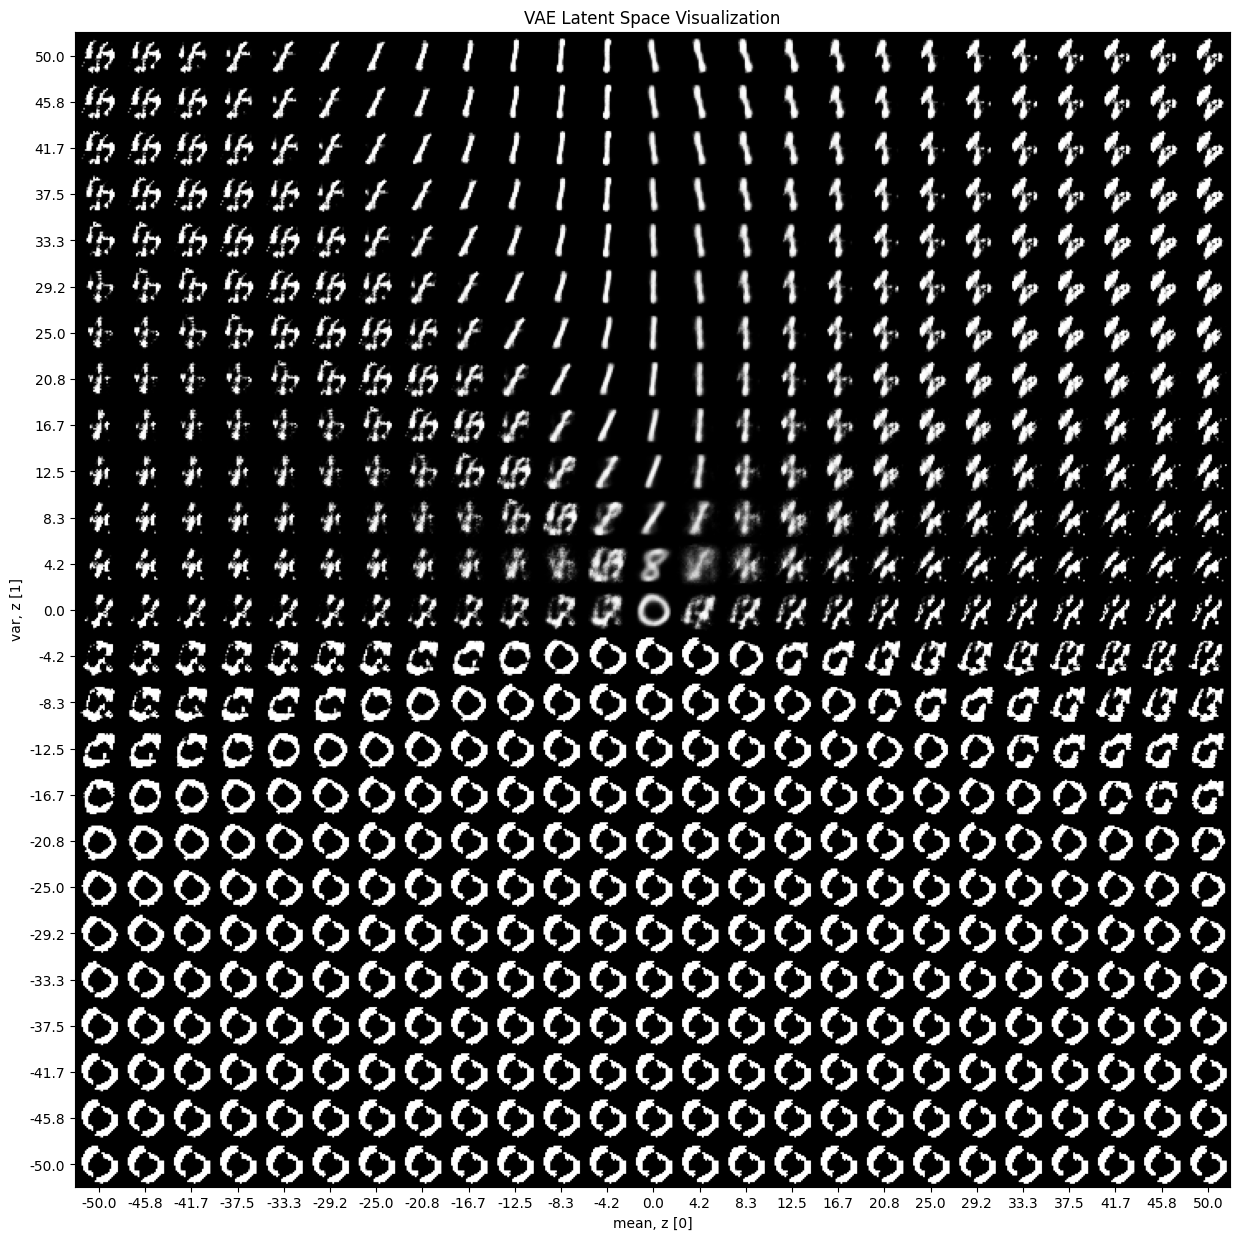

In [14]:
def plot_latent_space(model, scale=50.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)